# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import shap
from imblearn.over_sampling import SMOTE

# Load Wine Quality Dataset

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(url, delimiter=';')

# Define features and target

In [3]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values  # Multi-class classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization

In [4]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Handle Class Imbalance with SMOTE

In [5]:
print("\n🔹 Before SMOTE class distribution:")
print(pd.Series(y_train).value_counts())

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print("\n✅ After SMOTE class distribution:")
print(pd.Series(y_train).value_counts())


🔹 Before SMOTE class distribution:
5    551
6    506
7    157
4     43
8     13
3      9
Name: count, dtype: int64

✅ After SMOTE class distribution:
6    551
5    551
4    551
7    551
8    551
3    551
Name: count, dtype: int64


# Hyperparameter tuning for Decision Tree

In [6]:
param_grid = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Train Best Decision Tree Model
tree_model = grid_search.best_estimator_
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

# Feature Importance Using SHAP

 99%|===================| 19562/19836 [00:13<00:00]        

<Figure size 1000x600 with 0 Axes>

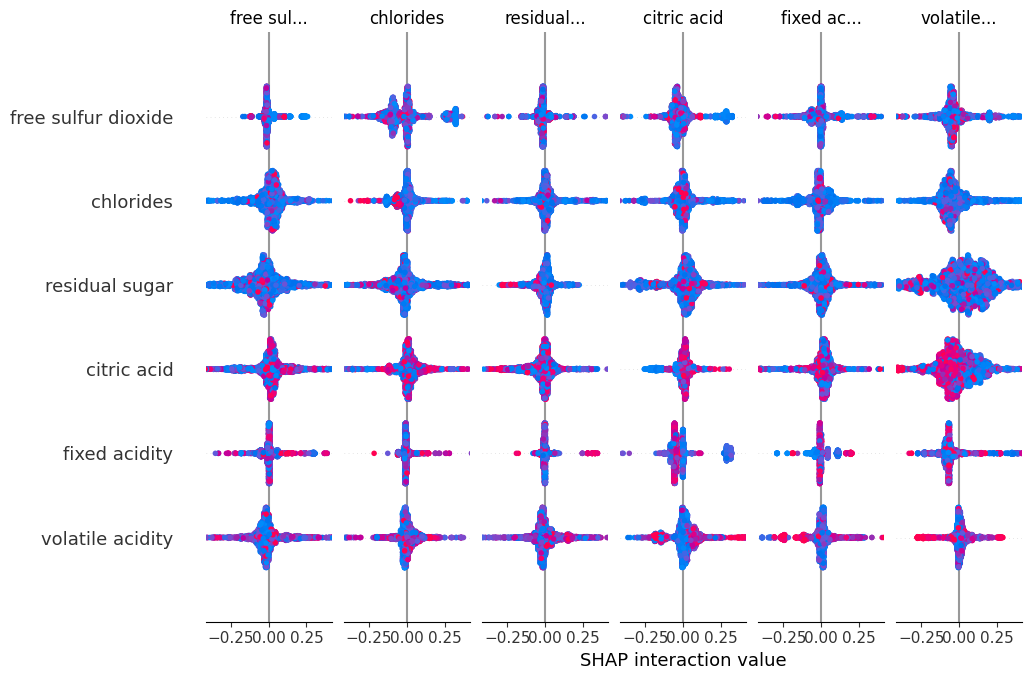

In [7]:
explainer = shap.Explainer(tree_model, X_train)
shap_values = explainer(X_train)

plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_train, feature_names=df.columns[:-1])

# Cost Complexity Pruning to Reduce Overfitting

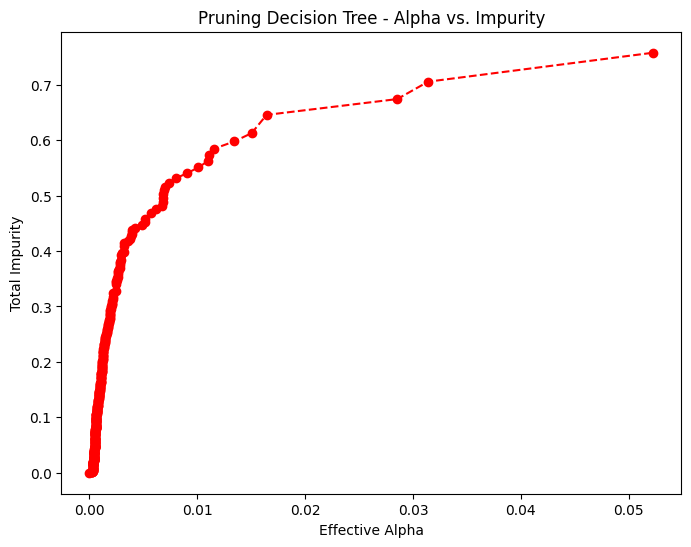

In [8]:
path = tree_model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# **Plot Alpha vs. Impurity**
plt.figure(figsize=(8, 6))
plt.plot(ccp_alphas[:-1], impurities[:-1], marker="o", linestyle="--", color="red")
plt.xlabel("Effective Alpha")
plt.ylabel("Total Impurity")
plt.title("Pruning Decision Tree - Alpha vs. Impurity")
plt.show()

In [9]:
# Evaluate Model Performance
y_pred = tree_model.predict(X_test)

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Decision Tree Accuracy: 0.57

Classification Report:
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.11      0.30      0.16        10
           5       0.71      0.68      0.70       130
           6       0.60      0.50      0.55       132
           7       0.56      0.60      0.57        42
           8       0.00      0.00      0.00         5

    accuracy                           0.57       320
   macro avg       0.33      0.35      0.33       320
weighted avg       0.61      0.57      0.59       320



# Confusion Matrix

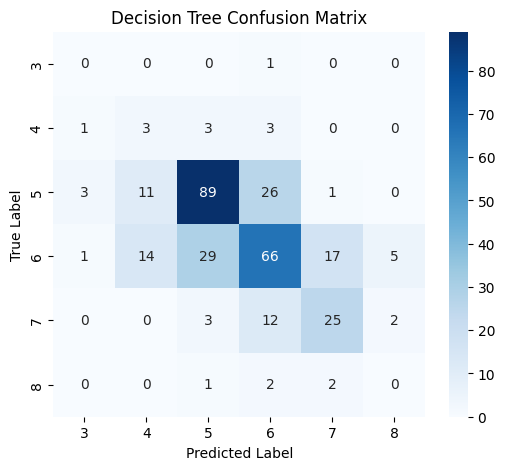

In [10]:
plt.figure(figsize=(6,5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Decision Tree Confusion Matrix")
plt.show()

# ROC Curve and AUC Score

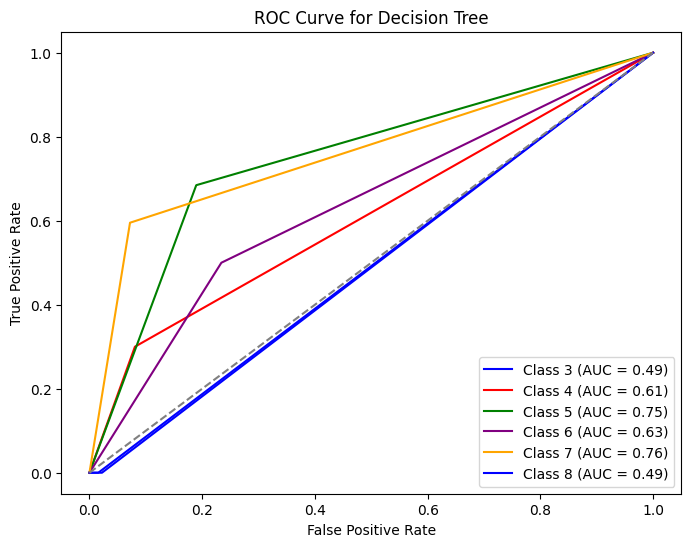

In [11]:
y_bin = label_binarize(y_test, classes=np.unique(y))
y_score = tree_model.predict_proba(X_test)

plt.figure(figsize=(8, 6))
colors = cycle(["blue", "red", "green", "purple", "orange"])
for i, color in zip(range(len(np.unique(y))), colors):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, label=f'Class {np.unique(y)[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Decision Tree")
plt.legend()
plt.show()